# 📦 Warehouse Pallet Allocation with Time-Based Visualization
This notebook builds an instance, solves the MIP allocation problem using Gurobi, prints assignment details, and generates a time-lapse GIF.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from gurobipy import Model, GRB, quicksum
import random
import os
from PIL import Image

def build_instance(num_pallets=40, blocks=2, corridors_per_block=5, positions_per_side=10, sides=2, levels=2):
    pallet_types = ['A', 'B']
    product_types = ['X', 'Y', 'Z']
    locations = []
    loc_id = 0
    for block in range(blocks):
        for corridor in range(corridors_per_block):
            for pos in range(positions_per_side):
                for side in range(sides):
                    for level in range(1, levels + 1):
                        x = block * 30 + corridor * 5 + pos
                        y = side * 10
                        locations.append({
                            'id': loc_id,
                            'x': x,
                            'y': y,
                            'level': level,
                            'pallet_type': random.choice(pallet_types)
                        })
                        loc_id += 1
    pallets = []
    for i in range(num_pallets):
        arrival = random.randint(1, 5)
        duration = random.randint(2, 7)
        departure = arrival + duration
        pallets.append({
            'id': i,
            'arrival': arrival,
            'departure': departure,
            'product_type': random.choice(product_types),
            'pallet_type': random.choice(pallet_types)
        })
    incompatible_pairs = [('X', 'Y'), ('Y', 'Z')]
    delta = 3
    return pallets, locations, incompatible_pairs, delta

def solve_model(pallets, locations, incompatible_pairs, delta):
    P = len(pallets)
    L = len(locations)
    model = Model("PalletAllocation")
    #model.setParam("OutputFlag", 0)
    model.setParam("TimeLimit", 600)  
    x = {}
    for i in range(P):
        for j in range(L):
            if pallets[i]['pallet_type'] == locations[j]['pallet_type']:
                x[i, j] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")
    model.update()
    obj = quicksum(x[i, j] * (abs(locations[j]['x']) + abs(locations[j]['y'])) for (i, j) in x)
    model.setObjective(obj, GRB.MINIMIZE)
    
    for i in range(P):
        model.addConstr(quicksum(x[i, j] for j in range(L) if (i, j) in x) == 1)
    
    T = list(range(1, 15))
    for j in range(L):
        for t in T:
            overlapping_pallets = [i for i in range(P) if (i, j) in x and pallets[i]['arrival'] <= t <= pallets[i]['departure']]
            if overlapping_pallets:
                model.addConstr(quicksum(x[i, j] for i in overlapping_pallets) <= 1)
    
    for i in range(P):
        for k in range(i + 1, P):
            if (pallets[i]['product_type'], pallets[k]['product_type']) in incompatible_pairs or                (pallets[k]['product_type'], pallets[i]['product_type']) in incompatible_pairs:
                if max(pallets[i]['arrival'], pallets[k]['arrival']) <= min(pallets[i]['departure'], pallets[k]['departure']):
                    for j in range(L):
                        for l in range(L):
                            if (i, j) in x and (k, l) in x:
                                dist = abs(locations[j]['x'] - locations[l]['x']) + abs(locations[j]['y'] - locations[l]['y'])
                                if dist < delta:
                                    model.addConstr(x[i, j] + x[k, l] <= 1)
    
    for i in range(1, P):
        for j in range(L):
            for k in range(j):
                if (i, j) in x and (i-1, k) in x:
                    model.addConstr(x[i, j] + x[i-1, k] <= 1)

    model.optimize()
    return model, x

def retrieve_assignments(model, x, pallets, locations):
    assignments = []
    for (i, j), var in x.items():
        if var.X > 0.5:
            assignments.append({
                'pallet': i,
                'location': j,
                'x': locations[j]['x'],
                'y': locations[j]['y'],
                'level': locations[j]['level']
            })
    return assignments

def print_solution(assignments, pallets, locations, model):
    pallet_lookup = {p['id']: p for p in pallets}
    print("\n📦 Instance Summary and Solution Metrics")
    print("=" * 45)
    print(f"Total Pallets           : {len(pallets)}")
    print(f"Total Storage Locations : {len(locations)}")
    print(f"Assigned Pallets        : {len(assignments)}")
    print(f"Total Distance Cost     : {model.ObjVal:.2f}")
    print("=" * 45)
    print("\nDetailed Assignments")
    for a in sorted(assignments, key=lambda d: d['pallet']):
        pallet = pallet_lookup[a['pallet']]
        loc = locations[a['location']]
        print(f"Pallet {a['pallet']:>2} → Location {a['location']:>3} "
              f"(x={loc['x']}, y={loc['y']}, level={loc['level']}), "
              f"Product={pallet['product_type']}, Type={pallet['pallet_type']}, "
              f"Time=[{pallet['arrival']}–{pallet['departure']}]")

def generate_time_frames(assignments, pallets, locations, output_folder="frames"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    pallet_lookup = {p['id']: p for p in pallets}
    product_color = {'X': 'red', 'Y': 'blue', 'Z': 'green'}
    T = list(range(1, 15))
    image_paths = []
    for t in T:
        fig, ax = plt.subplots(figsize=(16, 8))
        for loc in locations:
            block = loc['x'] // 50
            corridor = (loc['x'] % 50) // 5
            position = loc['x'] % 5
            side = 0 if loc['y'] == 0 else 1
            level = loc['level']
            x_disp = block * 60 + corridor * 6 + position
            y_disp = side * 6 + (level - 1)
            ax.add_patch(patches.Rectangle((x_disp, y_disp), 1, 1, edgecolor='gray', facecolor='none', linewidth=0.5))
        for a in assignments:
            pallet = pallet_lookup[a['pallet']]
            if pallet['arrival'] <= t <= pallet['departure']:
                loc = locations[a['location']]
                block = loc['x'] // 50
                corridor = (loc['x'] % 50) // 5
                position = loc['x'] % 5
                side = 0 if loc['y'] == 0 else 1
                level = loc['level']
                x_disp = block * 60 + corridor * 6 + position
                y_disp = side * 6 + (level - 1)
                color = product_color.get(pallet['product_type'], 'black')
                ax.add_patch(patches.Rectangle((x_disp, y_disp), 1, 1, edgecolor='black', facecolor=color, linewidth=1.2))
                ax.text(x_disp + 0.5, y_disp + 0.5, str(a['pallet']), ha='center', va='center', fontsize=8, color='white')
        ax.set_xlim(0, 120)
        ax.set_ylim(-1, 15)
        ax.set_aspect('equal')
        ax.set_title(f"Warehouse State – Day {t}")
        ax.axis('off')
        frame_path = os.path.join(output_folder, f"frame_{t:02d}.png")
        plt.tight_layout()
        plt.savefig(frame_path)
        image_paths.append(frame_path)
        plt.close()
    return image_paths

def create_gif_from_frames(image_paths, output_path="warehouse_animation.gif", duration=500):
    images = [Image.open(path) for path in image_paths]
    images[0].save(output_path, save_all=True, append_images=images[1:], duration=duration, loop=0)
    return output_path

if __name__ == "__main__":
    pallets, locations, incompatible_pairs, delta = build_instance()
    model, x = solve_model(pallets, locations, incompatible_pairs, delta)
    assignments = retrieve_assignments(model, x, pallets, locations)
    print_solution(assignments, pallets, locations, model)
    frame_paths = generate_time_frames(assignments, pallets, locations)
    gif_path = create_gif_from_frames(frame_paths)
    print(f"\n🎞️  GIF created at: {gif_path}")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-01
Set parameter TimeLimit to value 600
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1261363 rows, 8020 columns and 2559356 nonzeros
Model fingerprint: 0xafa568fa
Variable types: 0 continuous, 8020 integer (8020 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 884951 rows and 2 columns (presolve time = 5s) ...
Presolve removed 885001 rows and 17 columns
Presolve time: 7.91s
Presolved: 376362 rows, 8003 columns, 1398895 nonzeros
Variable types: 0 continuous, 8003 integer (8003 binary)
Found heuristic solution: objective 652.0000000
Root relaxation presolved: 8003 rows, 384352 columns, 1406868 nonzeros


Root s

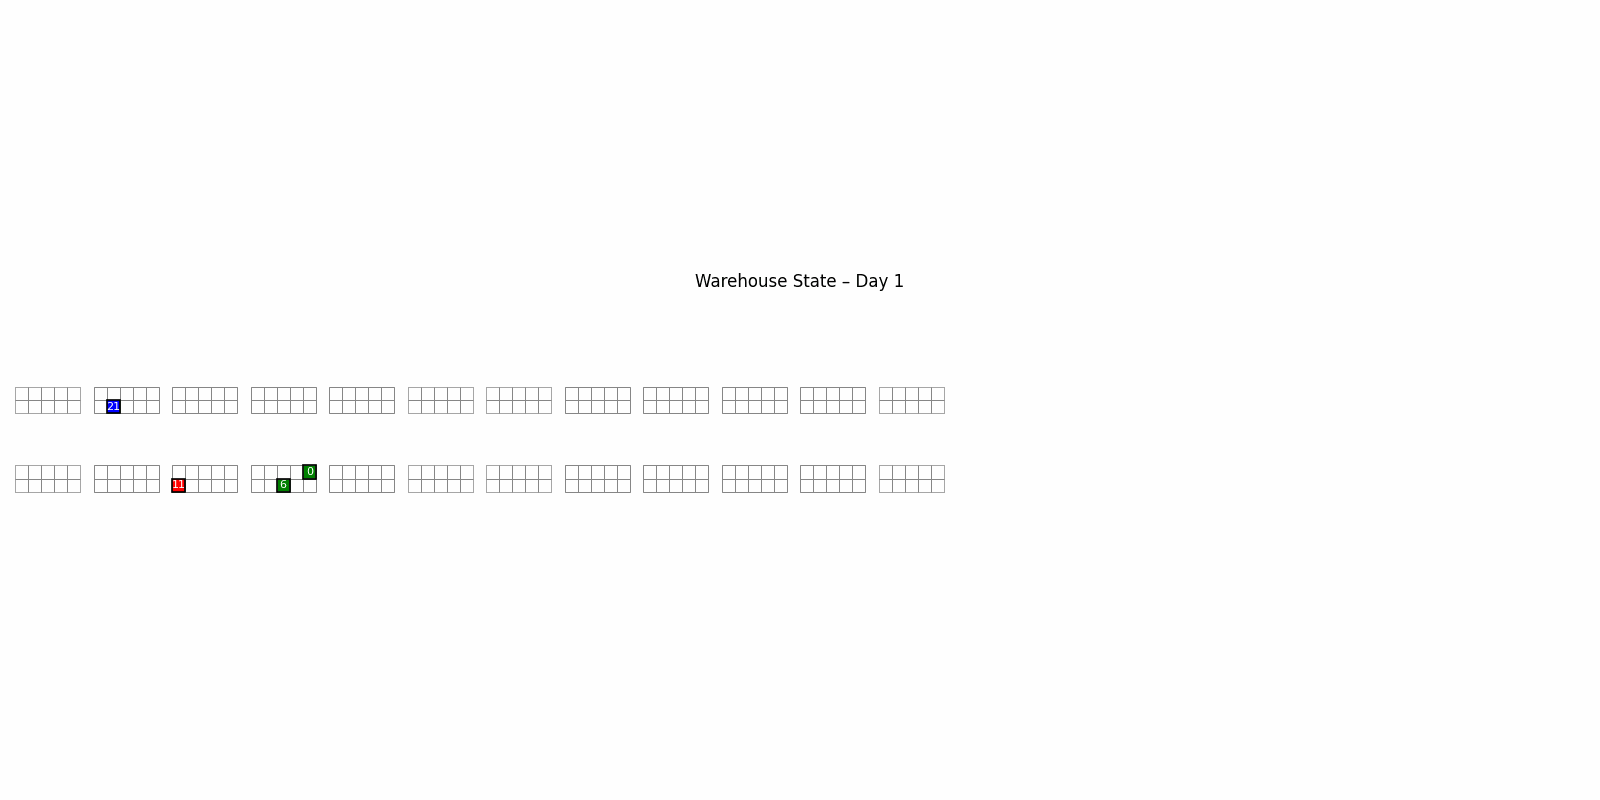

In [3]:
from IPython.display import Image as IPyImage
from IPython.display import display

# Display the generated GIF
display(IPyImage(filename="warehouse_animation.gif"))

/var/folders/m1/cbqcsbkd103bzwgrgqs_lpg40000gn/T/ipykernel_49004/3184483706.py:49: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


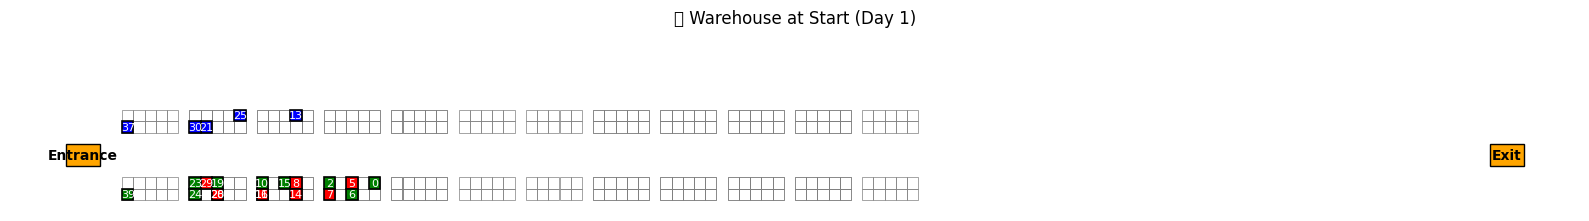

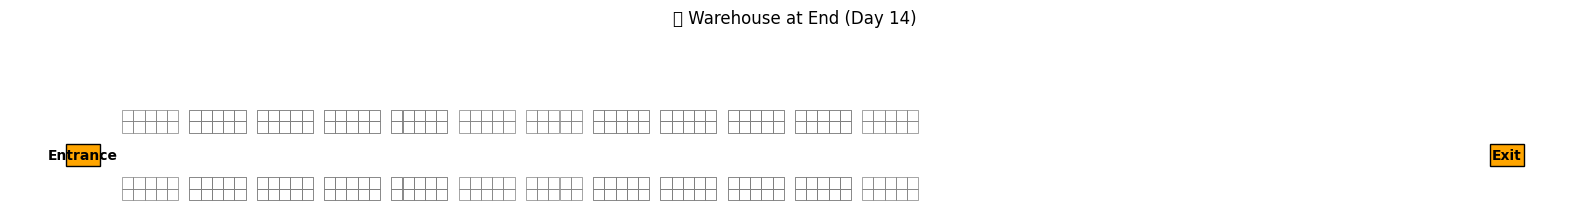

In [5]:


def plot_warehouse_state(assignments, pallets, locations, day, title=None):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    pallet_lookup = {p['id']: p for p in pallets}
    product_color = {'X': 'red', 'Y': 'blue', 'Z': 'green'}

    fig, ax = plt.subplots(figsize=(16, 8))

    # Plot entrance and exit doors
    ax.add_patch(patches.Rectangle((-5, 3), 3, 2, edgecolor='black', facecolor='orange'))
    ax.text(-3.5, 4, "Entrance", ha='center', va='center', fontsize=10, color='black', weight='bold')

    ax.add_patch(patches.Rectangle((122, 3), 3, 2, edgecolor='black', facecolor='orange'))
    ax.text(123.5, 4, "Exit", ha='center', va='center', fontsize=10, color='black', weight='bold')

    # Plot warehouse grid
    for loc in locations:
        block = loc['x'] // 50
        corridor = (loc['x'] % 50) // 5
        position = loc['x'] % 5
        side = 0 if loc['y'] == 0 else 1
        level = loc['level']
        x_disp = block * 60 + corridor * 6 + position
        y_disp = side * 6 + (level - 1)
        ax.add_patch(patches.Rectangle((x_disp, y_disp), 1, 1, edgecolor='gray', facecolor='none', linewidth=0.5))

    # Plot active pallets
    for a in assignments:
        pallet = pallet_lookup[a['pallet']]
        if pallet['arrival'] <= day <= pallet['departure']:
            loc = locations[a['location']]
            block = loc['x'] // 50
            corridor = (loc['x'] % 50) // 5
            position = loc['x'] % 5
            side = 0 if loc['y'] == 0 else 1
            level = loc['level']
            x_disp = block * 60 + corridor * 6 + position
            y_disp = side * 6 + (level - 1)
            color = product_color.get(pallet['product_type'], 'black')
            ax.add_patch(patches.Rectangle((x_disp, y_disp), 1, 1, edgecolor='black', facecolor=color, linewidth=1.2))
            ax.text(x_disp + 0.5, y_disp + 0.5, str(a['pallet']), ha='center', va='center', fontsize=8, color='white')

    ax.set_xlim(-10, 130)
    ax.set_ylim(-1, 15)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title or f"Warehouse State – Day {day}")
    plt.tight_layout()
    plt.show()


# Show the first and last day states
plot_warehouse_state(assignments, pallets, locations, day=3, title="📦 Warehouse at Start (Day 1)")
plot_warehouse_state(assignments, pallets, locations, day=14, title="📦 Warehouse at End (Day 14)")
